In [397]:
import pandas as pd
import numpy as np
import textwrap
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import requests
from bs4 import BeautifulSoup
import rouge
from IPython.display import display, HTML
import seaborn as sns
import matplotlib.pyplot as plt
from statistics import mean
import sumy
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
import re
import difflib

from vizualization import utils_split_sentences, display_string_matching


In [398]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Viktor_Shevchuk\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Viktor_Shevchuk\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [399]:
URL1 = "https://zakon.rada.gov.ua/laws/show/en/1207-18/conv/print"
URL2 = "https://zakon.rada.gov.ua/laws/show/en/1700-18/print"
URL3 = "https://zakon.rada.gov.ua/laws/show/en/254%D0%BA/96-%D0%B2%D1%80/print"
page = requests.get(URL1)

# print(page.text)


In [400]:
soup = BeautifulSoup(page.content, "html.parser")
# soup

In [401]:
paragraphs = soup.select('.rvts0 > .rvps2')
# paragraphs

In [402]:
legal_stop_words = [
    "amended", "restated", "be stated", "supplemented", "section", "paragraph", "article", "as follows"
]


In [403]:
def is_sentence_with_stopWord(para):
    for word in legal_stop_words:
        sentence_with_stopWord = para.find(
            text=lambda t: word in t.text.lower()
        )

        if sentence_with_stopWord:
            return True


In [404]:
def is_provisions(para):
    pattern = r"\b(?=[MDCLXVIΙ])M{0,4}(CM|CD|D?C{0,3})(XC|XL|L?X{0,3})([IΙ]X|[IΙ]V|V?[IΙ]{0,3})\b\.?"
    para_with_no_roman = re.sub(pattern, '', para.text.strip()).strip()

    return para_with_no_roman == "Final and transitional provisions"


In [405]:
def is_article_ensuring(para):
  return para.find("span", class_="rvts37")


In [406]:
def is_article_title(para):
    return para.find("span", class_="rvts9")


In [407]:
def is_closing_char(letter):
  return letter == "." or letter == ")"


In [408]:
def discard_ordered_list_numbers(text):
    is_first_char_numeric = text[0].isdigit()
    is_second_char_numeric = text[1].isdigit()
    is_third_char_numeric = text[2].isdigit()

    if is_first_char_numeric and is_closing_char(text[1]):
        return text[2:].strip()
    elif is_first_char_numeric and is_second_char_numeric and is_closing_char(text[2]):
        return text[3:].strip()
    elif is_first_char_numeric and is_second_char_numeric and is_third_char_numeric and is_closing_char(text[3]):
        return text[4:].strip()
    elif re.search(r"[a-z]", text[0]) and is_closing_char(text[1]):
        return text[2:].strip()

    return text


In [409]:
def is_sentence_end(sentence):
    last_character = sentence[-1]
    is_etc = sentence[-4:] == "etc."

    if last_character == "." and not is_etc:
        return True
    else:
        return False


In [410]:
def clean(paragraphs):
    cleaned = []
    article_ensuring = False
    concatenated_list = []
    ordered_list_with_stop_word = False

    for para in paragraphs:
        if article_ensuring and not is_article_title(para):
            continue
        elif article_ensuring and is_article_title(para):
            article_ensuring = False

        if is_article_ensuring(para):
            article_ensuring = True
            continue

        if is_provisions(para):
            return cleaned

        if is_article_title(para):
            continue

        text = para.text.strip()
        last_character = text[-1]

        if is_sentence_with_stopWord(para) and last_character == ":":
            ordered_list_with_stop_word = True
        elif not is_sentence_with_stopWord(para) and ordered_list_with_stop_word and is_sentence_end(text):
            ordered_list_with_stop_word = False
        elif not is_sentence_with_stopWord(para) and not ordered_list_with_stop_word:
            if last_character == ":" and not len(concatenated_list):
                concatenated_list.append(text)
            elif len(concatenated_list) and not is_sentence_end(text):
                concatenated_list.append(text)
            elif is_sentence_end(text) and len(concatenated_list):
                concatenated_list.append(text)
                cleaned.append(
                    discard_ordered_list_numbers(" ".join(concatenated_list))
                )
                concatenated_list.clear()
            elif not len(concatenated_list):
                cleaned.append(discard_ordered_list_numbers(text))

    return cleaned


In [411]:
cleaned_paragraphs = sent_tokenize(' '.join(clean(paragraphs)))
cleaned_paragraphs


['Under the Constitution of Ukraine, Ukraine is a sovereign and independent state.',
 'The sovereignty of Ukraine shall apply to its entire territory, which shall be integral and inviolable within the existing border.',
 "Presence of units of the other states' armed forces within the territory of Ukraine in violation of the procedure defined by the Constitution and laws of Ukraine, The Hague Conventions of 1907, the IV Geneva Convention of 1949, as well as in disregard of the Memorandum on Security Assurances in connection with Ukraine's accession to the Treaty on the Non-Proliferation of Nuclear Weapons of 1994, the Treaty on Friendship, Cooperation, and Partnership between Ukraine and the Russian Federation of 1997 and other international legal acts shall constitute occupation of a part of the territory of the sovereign state of Ukraine and an internationally unlawful act with all the consequences provided for by international law.",
 'The basis of the humanitarian, social and econom

In [412]:
stop_words = set(stopwords.words('english'))
type(stop_words)


set

In [413]:
stop_words.add('shall')
stop_words.add('.')
stop_words.add(',')
stop_words.add('(')
stop_words.add(')')
stop_words.add(';')
stop_words.add(':')
stop_words.add('—')
stop_words.add('-')

In [414]:
word_tokens = nltk.word_tokenize(" ".join(cleaned_paragraphs))



In [415]:
# converts the words in word_tokens to lower case and then checks whether they are present in stop_words or not
filtered_sentence = [w.lower()
                     for w in word_tokens if not w.lower() in stop_words]
# with lower case conversion



In [416]:
'''
Compute n-grams frequency with nltk tokenizer.
:parameter
    :param corpus: list - dtf["text"]
    :param ngrams: int or list - 1 for unigrams, 2 for bigrams, [1,2] for both
    :param top: num - plot the top frequent words
:return
    dtf_count: dtf with word frequency
'''


def word_freq(corpus, ngrams=[1, 2, 3], top=10, figsize=(10, 7)):
    lst_tokens = nltk.tokenize.word_tokenize(corpus)
    ngrams = [ngrams] if type(ngrams) is int else ngrams

    # calculate
    dtf_freq = pd.DataFrame()
    for n in ngrams:
        dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, n))
        dtf_n = pd.DataFrame(dic_words_freq.most_common(),
                             columns=["word", "freq"])
        dtf_n["ngrams"] = n
        dtf_freq = dtf_freq.append(dtf_n)
    dtf_freq["word"] = dtf_freq["word"].apply(
        lambda x: " ".join(string for string in x))
    dtf_freq = dtf_freq.sort_values(
        ["ngrams", "freq"], ascending=[True, False])

    # plot
    fig, ax = plt.subplots(figsize=figsize)
    sns.barplot(x="freq", y="word", hue="ngrams", dodge=False, ax=ax,
                data=dtf_freq.groupby('ngrams')[
                    "ngrams", "freq", "word"].head(top)
                )
    ax.set(xlabel=None, ylabel=None, title="Most frequent words")
    ax.grid(axis="x")
    plt.show()
    return dtf_freq


C:\Users\Viktor_Shevchuk\AppData\Local\Temp\ipykernel_53312\2931158815.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dtf_freq = dtf_freq.append(dtf_n)
C:\Users\Viktor_Shevchuk\AppData\Local\Temp\ipykernel_53312\2931158815.py:32: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data=dtf_freq.groupby('ngrams')[


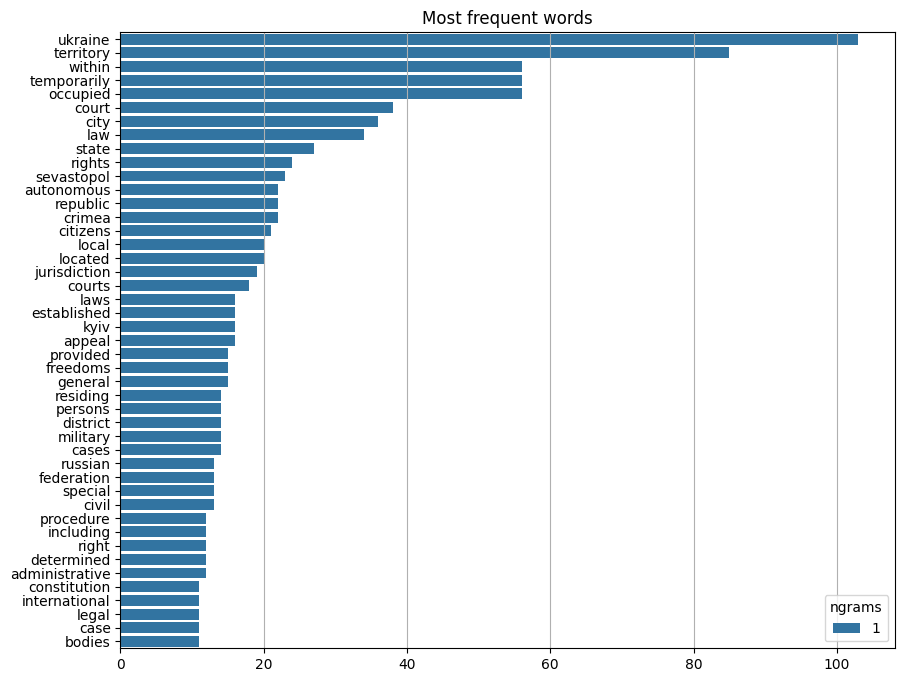

In [417]:
# Find most common words in text
freq = word_freq(
    corpus=" ".join(filtered_sentence),
    ngrams=[1],
    top=45,
    figsize=(10, 8)
)


In [418]:
tokened_sent = sent_tokenize(" ".join(cleaned_paragraphs))

main_dict = {}

for item in tokened_sent:
    item1 = list(item.split(" "))
    item2 = [' '.join(item1)]
    Length = []
    Length.append(len(item1))
    mydict = dict(zip(item2, Length))
    main_dict.update(mydict)

print('Maximum word amount in a sentence: ', max(main_dict.values()))
print('Minimum word amount in a sentence: ', min(main_dict.values()))
print('Average word amount in a sentence: ', mean(main_dict.values()))


Maximum word amount in a sentence:  441
Minimum word amount in a sentence:  8
Average word amount in a sentence:  49.9873417721519


In [419]:
featurizer = TfidfVectorizer(
    stop_words=stopwords.words('english'), 
    # norm='l1'
)
# featurizer


In [420]:
X = featurizer.fit_transform(
    cleaned_paragraphs
)
# X

In [421]:
def get_sentence_score(tfidf_row):
    # return the average of the non-zero values of the tf-idf vector representation of a sentence
    x = tfidf_row[tfidf_row != 0]

    return x.mean()

In [422]:
scores = np.zeros(len(cleaned_paragraphs))
for i in range(len(cleaned_paragraphs)):
    score = get_sentence_score(X[i, :])
    scores[i] = score


In [423]:
sort_idx = np.argsort(-scores)
# sort_idx

In [424]:
for i in sort_idx[:20]:
    print("%.2f: %s" % (scores[i], cleaned_paragraphs[i]))

0.47: Re-transfer of the case shall not be allowed.
0.43: Under the Constitution of Ukraine, Ukraine is a sovereign and independent state.
0.38: The date of the beginning of the temporary occupation is 20 February 2014.
0.34: Relevant information on their search shall be provided to law enforcement agencies.
0.32: At the same time, information (note) about the place of stay of such a person shall not be entered in his/her passport.
0.32: Persons guilty of violating the requirements of this Law shall bear the responsibility provided for by law.
0.30: The modalities of economic activity in the temporarily occupied territory shall be determined by law.
0.30: The temporarily occupied territory of Ukraine (hereinafter referred to as the temporarily occupied territory) is an integral part of the territory of Ukraine, which is subject to the Constitution and laws of Ukraine.
0.28: Property rights within the temporarily occupied territory shall be protected under the legislation of Ukraine.
0.

In [425]:
# title = soup.find("span", class_="rvts23").text 
# title


In [426]:
def tf_idf_summarize(text):
    X = featurizer.fit_transform(text)
    scores = np.zeros(len(text))

    for i in range(len(text)):
        score = get_sentence_score(X[i, :])
        scores[i] = score

    sort_idx = np.argsort(-scores)
  
    summarized = ""

    for i in sort_idx[:10]:
        test = text[i]
        summarized += text[i] + " "

    return summarized.strip()


In [427]:
tf_idf_summarize(cleaned_paragraphs)


'Re-transfer of the case shall not be allowed. Under the Constitution of Ukraine, Ukraine is a sovereign and independent state. The date of the beginning of the temporary occupation is 20 February 2014. Relevant information on their search shall be provided to law enforcement agencies. At the same time, information (note) about the place of stay of such a person shall not be entered in his/her passport. Persons guilty of violating the requirements of this Law shall bear the responsibility provided for by law. The modalities of economic activity in the temporarily occupied territory shall be determined by law. The temporarily occupied territory of Ukraine (hereinafter referred to as the temporarily occupied territory) is an integral part of the territory of Ukraine, which is subject to the Constitution and laws of Ukraine. Property rights within the temporarily occupied territory shall be protected under the legislation of Ukraine. The sovereignty of Ukraine shall apply to its entire te

LexRank Algorithm is an unsupervised approach to summarization and is inspired by the PageRank algorithm. LexRank uses an IDF-modified cosine similarity score to improve the Pagerank score for document summarization. It summarizes the text based on graph-based centrality scoring of sentences.

If one sentence is very similar to other sentences in the text corpus, then that sentence is considered of great importance. Such sentences can be recommended to the users.

In [428]:
S = cosine_similarity(X)
# S

In [429]:
S.shape

(79, 79)

In [430]:
len(cleaned_paragraphs)


79

In [431]:
# normalize similarity matrix
S /= S.sum(axis=1, keepdims=True)


In [432]:
S[0].sum()

0.9999999999999998

In [433]:
# uniform transition matrix
U = np.ones_like(S) / len(S)


In [434]:
U[0].sum()

0.9999999999999997

In [435]:
# smoothed similarity matrix
factor = 0.15 
S = (1 - factor) * S + factor * U

In [436]:
S[0].sum()

0.9999999999999999

In [437]:
# find the limiting / stationary distribution
eigenvals, eigenvecs = np.linalg.eig(S.T)


In [438]:
# eigenvals

In [439]:
# eigenvecs[:, 0]


In [440]:
# eigenvecs[:, 0].dot(S)


In [441]:
scores = eigenvecs[:, 0] / eigenvecs[:, 0].sum()
sort_idx = np.argsort(-scores)


In [442]:
for i in sort_idx[:10]:
    print("%.2f: %s" % (scores[i], cleaned_paragraphs[i]))


0.02: Ukraine shall take all necessary measures to guarantee human and civil rights and freedoms provided for by the Constitution and laws of Ukraine, international treaties, to all citizens of Ukraine residing within the temporarily occupied territory.
0.02: In case of violation of the provisions of this Law, state bodies of Ukraine shall apply the mechanisms provided for by the laws of Ukraine and the norms of international law in order to protect the peace, security, rights, freedoms and legitimate interests of citizens of Ukraine located within the temporarily occupied territory, as well as the legitimate interests of the state of Ukraine.
0.02: Responsibility for violating human and civil rights and freedoms defined by the Constitution and laws of Ukraine within the temporarily occupied territory shall be assigned to the Russian Federation as an occupying state under the norms and principles of international law.
0.02: If it is impossible to carry out activities within the tempora

In [443]:
def textRankSummarize(text, factor=0.15):
    X = featurizer.fit_transform(text)
    S = cosine_similarity(X)  # compute similarity matrix
    S /= S.sum(axis=1, keepdims=True)  # normalize similarity matrix
    U = np.ones_like(S) / len(S)  # uniform transition matrix
    S = (1 - factor) * S + factor * U  # smooth similarity matrix
    # find the limiting / stationary distribution
    eigenvals, eigenvecs = np.linalg.eig(S.T)
    scores = eigenvecs[:, 0] / eigenvecs[:, 0].sum()  # compute scores
    sort_idx = np.argsort(-scores)  # sort scores

    summarized = ""

    for i in sort_idx[:10]:
        test = text[i]
        summarized += text[i] + " "

    return summarized.strip()


In [444]:
textRankSummarize(cleaned_paragraphs)


'Ukraine shall take all necessary measures to guarantee human and civil rights and freedoms provided for by the Constitution and laws of Ukraine, international treaties, to all citizens of Ukraine residing within the temporarily occupied territory. In case of violation of the provisions of this Law, state bodies of Ukraine shall apply the mechanisms provided for by the laws of Ukraine and the norms of international law in order to protect the peace, security, rights, freedoms and legitimate interests of citizens of Ukraine located within the temporarily occupied territory, as well as the legitimate interests of the state of Ukraine. Responsibility for violating human and civil rights and freedoms defined by the Constitution and laws of Ukraine within the temporarily occupied territory shall be assigned to the Russian Federation as an occupying state under the norms and principles of international law. If it is impossible to carry out activities within the temporarily occupied territory

Libraries for text summarization 

Latent Semantic Analysis (LSA) is based on term frequency techniques with singular value decomposition to summarize texts. LSA is an unsupervised NLP technique, and the aim of LSA is to create a representation of text data in terms of topics or latent features.

LSA consists of two steps:

- To generate a document term matrix (or numerical vector).
- To perform Singular Value Decomposition on document term matrix. SVD reduces the dimensionality of the original dataset by encoding it with latent features.

With LSA these latent features represent topics in the original data.


<img scr="https://miro.medium.com/max/720/1*NGT4fdWMy5pvDUpLRntuTQ.webp" alt="Steps of LSA" />
<p>Steps of LSA</p>


In [445]:
from sumy.summarizers.lsa import LsaSummarizer


In [446]:
parser = PlaintextParser.from_string(cleaned_paragraphs, Tokenizer("english"))
parser 

In [447]:
summarizer = LsaSummarizer()
summarizer


In [448]:
summary = summarizer(parser.document, sentences_count=10)
# summary
[str(sentence) for sentence in summary]


["', 'Elderly citizens, persons with disabilities, children with disabilities and other citizens of Ukraine experiencing difficult life circumstances and residing within the temporarily occupied territory shall have the right to be provided with social services under the legislation of Ukraine.",
 '\', \'Foreigners and stateless persons permanently residing in Ukraine, persons who have been granted refugee status in Ukraine, persons in need of additional or temporary protection, and persons who have been granted the status of a foreign Ukrainian, who are legally staying in Ukraine and live within the temporarily occupied territory, shall have the right to get or continue getting a certain qualification within the territory of other regions of Ukraine following the procedure defined by the laws of Ukraine “On Higher Education” and “On Professional Pre-higher Education".',
 "', 'During presidential, parliamentary elections and all-Ukrainian referendums, voting of Ukrainian citizens withi

In [449]:
# Luhn
from sumy.summarizers.luhn import LuhnSummarizer
# text: text to summarize
# no_sentences: number of sentences in your summary,
# lang: language of text


def luhn_summary(text, no_sentences, lang):
    parser = PlaintextParser(text, Tokenizer(lang))
    luhn_sum = LuhnSummarizer()
    summary = luhn_sum(parser.document, no_sentences)
    return [str(sentence) for sentence in summary]


In [450]:
luhn_summary(cleaned_paragraphs, 10, "english")


['\', "Presence of units of the other states\' armed forces within the territory of Ukraine in violation of the procedure defined by the Constitution and laws of Ukraine, The Hague Conventions of 1907, the IV Geneva Convention of 1949, as well as in disregard of the Memorandum on Security Assurances in connection with Ukraine\'s accession to the Treaty on the Non-Proliferation of Nuclear Weapons of 1994, the Treaty on Friendship, Cooperation, and Partnership between Ukraine and the Russian Federation of 1997 and other international legal acts shall constitute occupation of a part of the territory of the sovereign state of Ukraine and an internationally unlawful act with all the consequences provided for by international law.',
 "', 'This Law defines the status of the territory of Ukraine, which is temporarily occupied as a result of the armed aggression of the Russian Federation, establishes a special legal regime within this territory, defines the specifics of functioning of governmen

In [451]:
# KL
from sumy.summarizers.kl import KLSummarizer
# text: text to summarize
# no_sentences: number of sentences in your summary,
# lang: language of text


def kl_summary(text, no_sentences, lang):
    parser = PlaintextParser.from_string(text, Tokenizer(lang))
    kl_summarizer = KLSummarizer()
    summary = kl_summarizer(parser.document, sentences_count=no_sentences)
    return [str(sentence) for sentence in summary]


In [452]:
kl_summary(cleaned_paragraphs, 10, "english")


["', 'The date of the beginning of the temporary occupation is 20 February 2014.",
 "', 'The legal regime of the temporarily occupied territory shall provide for a special procedure for ensuring the rights and freedoms of Ukrainian citizens living in the temporarily occupied territory.",
 "', 'At the same time, information (note) about the place of stay of such a person shall not be entered in his/her passport.",
 "', 'An example and procedure for issuing a certificate confirming the place of stay, an example of a written application that should be submitted by a citizen for obtaining a certificate, shall be approved by the central executive authority in charge of shaping the state policy in the field of migration (immigration and emigration), including countering illegal (unlawful) migration, citizenship, registration of individuals, refugees and other categories of migrants defined by law.",
 "', 'Bodies for keeping the State Register of Voters established in the territory of the Aut

TextRank vs Seq2Seq vs BART

The hardest NLP tasks are the ones where the output isn’t a single label or value (like Classification and Regression), but a full new text (like Translation, Summarization and Conversation).

Text summarization is the problem of reducing the number of sentences and words of a document without changing its meaning. There are different techniques to extract information from raw text data and use it for a summarization model, overall they can be categorized as Extractive and Abstractive. Extractive methods select the most important sentences within a text (without necessarily understanding the meaning), therefore the result summary is just a subset of the full text. On the contrary, Abstractive models understand the semantics of the text and generate a meaningful summary. 

I’ll keep On Ensuring Civil Rights and Freedoms, and the Legal Regime on the Temporarily Occupied Territory of Ukraine summary on dentons to compare different models.

In [453]:
human_summary = """On 15 April 2014 the Ukrainian Parliament passed the Law of Ukraine “On Ensuring Civil Rights and Freedoms and the Legal Regime on Temporarily Occupied Territory of Ukraine” (the "Law").
Specifically, the Law determines a legal regime of occupied territories as well as sets forth special procedures for the operation of governmental authorities, bodies of local self-government, enterprises and organizations, under such legal regime, provides for protection of human and civil rights and freedoms as well as rights, freedoms and lawful interests of legal entities and indicates Ukrainian courts that will consider disputes arising in Crimea during the occupation.
It defines "occupied territory" as including the land territory of the Autonomous Republic of Crimea and the city of Sevastopol as well as their domestic waters; domestic waters and territorial sea of Ukraine adjacent to the coast of the Crimean peninsula; the territory of an adjacent area, exclusive economic zone and continental shelf along the coast of the Crimean peninsula subject to jurisdiction of Ukrainian bodies of state power in accordance with provisions of international law, the Constitution and laws of Ukraine; underwater space within the territorial sea; air space above these territories.
For as long as Crimea remains occupied, the "occupied territory" will be subjected to a special legal regime with respect to the border crossing with the "occupied territory", carrying out business activity, entering into transactions, holding elections and referenda, exercise of other human and civil rights and freedoms as well as a special procedure for ensuring human and civil rights and freedoms of Ukrainian citizens residing in the temporarily occupied territories of Ukraine.
1) Activities of state and local self-governance bodies created in the occupied territories in breach of Ukrainian law shall be prohibited, and their regulations and acts shall be illegal and will not be recognized in Ukraine - e.g. permits, authorizations, allocation of  land plots.
2) The Law specifically deals with transfers of Crimea-based immovable property by setting forth that ownership rights to immovable property may be transferred and acquired in accordance with Ukrainian law. As a result, Crimea-based immovable property may be transferred outside Crimea and notarized by any Ukrainian notary.
3) Disputes arising in Crimea during the occupation will be considered by respective civil, commercial and administrative courts in the city of Kyiv.
4) If provisions of the Law are violated, Ukrainian authorities shall apply mechanisms provided for by Ukrainian law and provisions of international laws both in Ukrainian and international courts.
Business activities in Crimea will be covered by a separate law intended to specifically address the "doing business in Crimea" aspect.
Generally, the Law limits business activity in the territory of Crimea and, obviously, persons engaged in business activity in Crimea may be prosecuted by Ukraine and the international community (i.e., the countries that did not recognize the occupation of Crimea by the Russian Federation). Considering this, the Ministry of Justice of Ukraine introduced a simplified procedure for Crimea-registered businesses to change their registered addresses. Accordingly, Crimea-registered businesses may now register anywhere in Ukraine and continue with their businesses."""


How can we evaluate the results? 

In [454]:
'''
Calculate ROUGE score.
:parameter    
    :param y_test: string or list    
    :param predicted: string or list
'''
def evaluate_summary(y_test, predicted):
    rouge_score = rouge.Rouge()
    scores = rouge_score.get_scores(y_test, predicted, avg=True)
    score_1 = round(scores['rouge-1']['f'], 2)
    score_2 = round(scores['rouge-2']['f'], 2)
    score_L = round(scores['rouge-l']['f'], 2)
    print("rouge1:", score_1, "| rouge2:", score_2, "| rougeL:",
          score_2, "--> avg rouge:", round(np.mean(
              [score_1, score_2, score_L]), 2))


In [455]:
evaluate_summary(
    human_summary,
    tf_idf_summarize(cleaned_paragraphs)
)


rouge1: 0.22 | rouge2: 0.07 | rougeL: 0.07 --> avg rouge: 0.16


The results show that 22% of unigrams (ROUGE-1) and 7% of bigrams (ROUGE-2) are present in both summaries, while the longest common subsequences (ROUGE-L) match by 7%. Overall, the average score is 16%. ROUGE scores don’t measure how fluent the summary is. For that experts recomend using the good old human eye. 

In [456]:
evaluate_summary(
    human_summary,
    textRankSummarize(cleaned_paragraphs)
)


rouge1: 0.33 | rouge2: 0.17 | rougeL: 0.17 --> avg rouge: 0.27


Visualization: I will display 2 texts, i.e. the summary and the original text, or the predicted summary and the real summary, and highlight the matching parts. It highlights the matching substrings of two texts. It can be used on word-level.

In [457]:
'''
Find the matching substrings in 2 strings.
:parameter
    :param a: string - raw text
    :param b: string - raw text
:return
    2 lists used in to display matches
'''


def utils_split_sentences(a, b):
    # find clean matches
    match = difflib.SequenceMatcher(isjunk=None, a=a, b=b, autojunk=True)
    lst_match = [block for block in match.get_matching_blocks()
                 if block.size > 20]

    # difflib didn't find any match
    if len(lst_match) == 0:
        lst_a, lst_b = sent_tokenize(a), sent_tokenize(b)

    # work with matches
    else:
        first_m, last_m = lst_match[0], lst_match[-1]

        # a
        string = a[0: first_m.a]
        lst_a = [t for t in sent_tokenize(string)]
        for n in range(len(lst_match)):
            m = lst_match[n]
            string = a[m.a: m.a+m.size]
            lst_a.append(string)
            if n+1 < len(lst_match):
                next_m = lst_match[n+1]
                string = a[m.a+m.size: next_m.a]
                lst_a = lst_a + [t for t in sent_tokenize(string)]
            else:
                break
        string = a[last_m.a+last_m.size:]
        lst_a = lst_a + [t for t in sent_tokenize(string)]

        # b
        string = b[0: first_m.b]
        lst_b = [t for t in sent_tokenize(string)]
        for n in range(len(lst_match)):
            m = lst_match[n]
            string = b[m.b: m.b+m.size]
            lst_b.append(string)
            if n+1 < len(lst_match):
                next_m = lst_match[n+1]
                string = b[m.b+m.size: next_m.b]
                lst_b = lst_b + [t for t in sent_tokenize(string)]
            else:
                break
        string = b[last_m.b+last_m.size:]
        lst_b = lst_b + [t for t in sent_tokenize(string)]

    return lst_a, lst_b

'''
Highlights the matched strings in text.
:parameter
    :param a: string - raw text
    :param b: string - raw text
    :param both: bool - search a in b and, if True, viceversa
    :param sentences: bool - if False matches single words
:return
    text html, it can be visualized on notebook with display(HTML(text))
'''


def display_string_matching(a, b, both=True, sentences=True, titles=[]):
    if sentences is True:
        lst_a, lst_b = utils_split_sentences(a, b)
    else:
        lst_a, lst_b = a.split(), b.split()

    # highlight a
    first_text = []
    for i in lst_a:
        if re.sub(r'[^\w\s]', '', i.lower()) in [re.sub(r'[^\w\s]', '', z.lower()) for z in lst_b]:
            first_text.append(
                '<span style="background-color:rgba(255,215,0,0.3);">' + i + '</span>')
        else:
            first_text.append(i)
    first_text = ' '.join(first_text)

    # highlight b
    second_text = []
    if both is True:
        for i in lst_b:
            if re.sub(r'[^\w\s]', '', i.lower()) in [re.sub(r'[^\w\s]', '', z.lower()) for z in lst_a]:
                second_text.append(
                    '<span style="background-color:rgba(255,215,0,0.3);">' + i + '</span>')
            else:
                second_text.append(i)
    else:
        second_text.append(b)
    second_text = ' '.join(second_text)

    # concatenate
    if len(titles) > 0:
        first_text = "<strong>"+titles[0]+"</strong><br>"+first_text
    if len(titles) > 1:
        second_text = "<strong>"+titles[1]+"</strong><br>"+second_text
    else:
        second_text = "---"*65+"<br><br>"+second_text
    final_text = first_text + '<br><br>' + second_text
    return final_text


In [458]:
match = display_string_matching(
    human_summary,
    tf_idf_summarize(cleaned_paragraphs),
    both=True,
    sentences=False,
    titles=["Real Summary", "tfIDF Predicted Summary"]
)


In [459]:
# display(HTML(match))


In [460]:
match = display_string_matching(
    human_summary,
    textRankSummarize(cleaned_paragraphs),
    both=True,
    sentences=False,
    titles=["Real Summary", "Text Rank Predicted Summary"]
)


In [461]:
# display(HTML(match))


In [462]:
match = display_string_matching(
    ' '.join(cleaned_paragraphs),
    tf_idf_summarize(cleaned_paragraphs),
    both=True,
    titles=["Full Text", "tfIDF Predicted Summary"]
)

# display(HTML(match))


In [463]:
match = display_string_matching(
    ' '.join(cleaned_paragraphs),
    textRankSummarize(cleaned_paragraphs),
    both=True,
    titles=["Full Text", "Text Rank Predicted Summary"]
)

# display(HTML(match))


The prediction has most of the information mentioned in the original summary. As expected from an Extractive algorithms, the predicted summary is fully contained in the text: the model considers those the most important sentences.

For our purposes in this chapter, we can
also use the tokenizers from NLTK to build a simple text summarizer that is based on
Luhn's method that he wrote about in The automatic creation of literature abstracts. This
basic, extractive program will first tokenize each sentence in the text sample, then
choose which words occur most frequently while excluding unimportant words,
called stopwords, and finally it will find the sentence or sentences that include the
important words.


Our program will include one other subtle effect. We will construct a score for each
sentence based on the aggregated scores of the words inside it. For example, suppose
the word cat appears in a text 10 times, and the word hat appears three times. The
sentence The cat wears a hat will score a 13, or the score for cat plus the score for hat.
The sentence His hat is different than her hat will only score 3, since the score for hat is
counted only once. This scoring system has the advantage of privileging sentences
that have a variety of important words in them, while minimizing the effect of
sentences that have fewer important words, even if those words are repeated
multiple times. The rationale for this scoring system is that sentences with a variety
of important words are more likely to be topic sentences or main ideas, and topic
sentences are more relevant for building a summary.


==


In [464]:
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from collections import OrderedDict
import pprint


In [465]:
text = " ".join(cleaned_paragraphs)
summary_sentences = []
candidate_sentences = {}
candidate_sentence_counts = {}


In [466]:
words = word_tokenize(text)
# words


In [467]:
lowercase_words = [word.lower() for word in words
                   if word not in stopwords.words() and word.isalpha()]
lowercase_words


['under',
 'constitution',
 'ukraine',
 'ukraine',
 'sovereign',
 'independent',
 'state',
 'the',
 'sovereignty',
 'ukraine',
 'apply',
 'entire',
 'territory',
 'integral',
 'inviolable',
 'existing',
 'border',
 'presence',
 'units',
 'states',
 'armed',
 'forces',
 'territory',
 'ukraine',
 'violation',
 'procedure',
 'defined',
 'constitution',
 'laws',
 'ukraine',
 'the',
 'hague',
 'conventions',
 'iv',
 'geneva',
 'convention',
 'disregard',
 'memorandum',
 'security',
 'assurances',
 'connection',
 'ukraine',
 'accession',
 'treaty',
 'nuclear',
 'weapons',
 'treaty',
 'friendship',
 'cooperation',
 'partnership',
 'ukraine',
 'russian',
 'federation',
 'international',
 'legal',
 'acts',
 'constitute',
 'occupation',
 'part',
 'territory',
 'sovereign',
 'state',
 'ukraine',
 'internationally',
 'unlawful',
 'act',
 'consequences',
 'provided',
 'international',
 'law',
 'the',
 'basis',
 'humanitarian',
 'social',
 'economic',
 'policy',
 'ukraine',
 'relation',
 'population

In [468]:
word_frequencies = FreqDist(lowercase_words)
most_frequent_words = FreqDist(lowercase_words).most_common(25)
most_frequent_words


[('ukraine', 103),
 ('territory', 85),
 ('temporarily', 56),
 ('occupied', 56),
 ('court', 38),
 ('city', 36),
 ('law', 34),
 ('state', 27),
 ('rights', 24),
 ('sevastopol', 23),
 ('autonomous', 22),
 ('republic', 22),
 ('crimea', 22),
 ('citizens', 21),
 ('local', 20),
 ('located', 20),
 ('jurisdiction', 19),
 ('courts', 18),
 ('laws', 16),
 ('established', 16),
 ('kyiv', 16),
 ('appeal', 16),
 ('provided', 15),
 ('freedoms', 15),
 ('general', 15)]

In [469]:
sentences = sent_tokenize(text)
for sentence in sentences:
    candidate_sentences[sentence] = sentence.lower()


In [470]:
for long, short in candidate_sentences.items():
    count = 0
    for freq_word, frequency_score in most_frequent_words:
        if freq_word in short:
            count += frequency_score
            candidate_sentence_counts[long] = count


In [471]:
sorted_sentences = OrderedDict(sorted(
    candidate_sentence_counts.items(),
    key=lambda x: x[1],
    reverse=True)[:4])
print(sorted_sentences)

OrderedDict([('Ukraine, the Autonomous Republic of Crimea, territorial communities, including the territorial community of the city of Sevastopol, government and local authorities and other legal entities of public law shall retain the right of ownership and other real rights to property, including real estate, including land plots located within the temporarily occupied territory.', 550), ('For the purposes of this Law, the temporarily occupied territory is defined as: 1) land territory of the Autonomous Republic of Crimea and the city of Sevastopol, the internal waters of these territories of Ukraine; 2) internal sea waters and territorial sea of Ukraine around the Crimean Peninsula, the territory of the exclusive (maritime) economic zone of Ukraine along the coast of the Crimean Peninsula and adjacent to the coast of the continental shelf of Ukraine, which fall under the jurisdiction of government authorities of Ukraine under the norms of international law, the Constitution and laws

In [472]:
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.luhn import LuhnSummarizer
from sumy.summarizers.text_rank import TextRankSummarizer
from sumy.summarizers.lex_rank import LexRankSummarizer
from sumy.summarizers.lsa import LsaSummarizer
from sumy.summarizers.kl import KLSummarizer
from sumy.summarizers.reduction import ReductionSummarizer
from sumy.summarizers.edmundson import EdmundsonSummarizer
from sumy.summarizers.random import RandomSummarizer
from sumy.summarizers.sum_basic import SumBasicSummarizer
from sumy.nlp.stemmers import Stemmer
from sumy.utils import get_stop_words


In [473]:
LANGUAGE = "english"
SENTENCES_COUNT = 7
parser = PlaintextParser.from_string(text, Tokenizer(LANGUAGE))
stemmer = Stemmer(LANGUAGE)


In [474]:
def make_summarization(method):
    summarized = []
    summarizer = method(stemmer)
    summarizer.stop_words = get_stop_words(LANGUAGE)
    for sentence in summarizer(parser.document, SENTENCES_COUNT):
        summarized.append(sentence)

    return ' '.join(str(v) for v in summarized)


In [475]:
evaluate_summary(
    human_summary,
    make_summarization(RandomSummarizer)
)


rouge1: 0.23 | rouge2: 0.09 | rougeL: 0.09 --> avg rouge: 0.18


In [476]:
def make_sum_basic_summarization():
    summarized = []
    summarizer = SumBasicSummarizer()
    summarizer.stop_words = get_stop_words(LANGUAGE)
    for sentence in summarizer(parser.document, SENTENCES_COUNT):
        summarized.append(sentence)

    return ' '.join(str(v) for v in summarized)


In [477]:
evaluate_summary(
    human_summary,
    make_sum_basic_summarization()
)


rouge1: 0.24 | rouge2: 0.11 | rougeL: 0.11 --> avg rouge: 0.19


In [478]:
evaluate_summary(
    human_summary,
    make_summarization(LuhnSummarizer)
)


rouge1: 0.34 | rouge2: 0.15 | rougeL: 0.15 --> avg rouge: 0.26


In [479]:
evaluate_summary(
    human_summary,
    make_summarization(ReductionSummarizer)
)


rouge1: 0.35 | rouge2: 0.16 | rougeL: 0.16 --> avg rouge: 0.27


In [480]:
evaluate_summary(
    human_summary,
    make_summarization(KLSummarizer)
)


rouge1: 0.28 | rouge2: 0.15 | rougeL: 0.15 --> avg rouge: 0.23


In [481]:
evaluate_summary(
    human_summary,
    make_summarization(LexRankSummarizer)
)


rouge1: 0.33 | rouge2: 0.18 | rougeL: 0.18 --> avg rouge: 0.27


In [482]:
evaluate_summary(
    human_summary,
    make_summarization(TextRankSummarizer)
)


rouge1: 0.35 | rouge2: 0.16 | rougeL: 0.16 --> avg rouge: 0.27


In [483]:
evaluate_summary(
    human_summary,
    make_summarization(LsaSummarizer)
)


rouge1: 0.29 | rouge2: 0.11 | rougeL: 0.11 --> avg rouge: 0.22


In [484]:
def make_edmundson_summarization():
    summarized = []
    summarizer = EdmundsonSummarizer(stemmer)
    summarizer.bonus_words = ('foo')
    summarizer.stigma_words = ('foo')
    summarizer.null_words = ('foo')
    for sentence in summarizer(parser.document, SENTENCES_COUNT):
        summarized.append(sentence)

    return ' '.join(str(v) for v in summarized)


In [485]:
evaluate_summary(
    human_summary,
    make_edmundson_summarization()
)

rouge1: 0.23 | rouge2: 0.09 | rougeL: 0.09 --> avg rouge: 0.17


In [486]:
tl_dr_this_summary = """Official translation Last modification: 31.05.21 07:36:24 LAW OF UKRAINE On Ensuring Civil Rights and Freedoms, and the Legal Regime on the Temporarily Occupied Territory of Ukraine (The Official Bulletin of the Verkhovna Rada of Ukraine (BVR), 2014, No.
1706-VII of 20 October 2014, BVR, 2015, No.
The legal regime of the temporarily occupied territory shall provide for a special procedure for ensuring the rights and freedoms of Ukrainian citizens living in the temporarily occupied territory.
{Article 12 has been supplemented with part four as amended by Law No.
The procedure provided for in this Article for summoning to court and notification of a court decision may be applied to other parties to the litigation with the address of place of residence (stay), location or place of work within the temporarily occupied territory, if the exercise of their procedural rights and obligations depends on it.
Acquisition of the right of private ownership to residential premises specified in part 1 of this Article, located within the temporarily occupied territory, by military personnel of military formations and law enforcement agencies of Ukraine and members of their families shall not deprive them of the right to privatise housing located in another territory of Ukraine, under the Law of Ukraine “On Privatisation of State Housing Stock”."""

In [487]:
evaluate_summary(
    human_summary,
    tl_dr_this_summary
)


rouge1: 0.26 | rouge2: 0.12 | rougeL: 0.12 --> avg rouge: 0.21


In [488]:
smmry_summary = """Presence of units of the other states' armed forces within the territory of Ukraine in violation of the procedure defined by the Constitution and laws of Ukraine, The Hague Conventions of 1907, the IV Geneva Convention of 1949, as well as in disregard of the Memorandum on Security Assurances in connection with Ukraine's accession to the Treaty on the Non-Proliferation of Nuclear Weapons of 1994, the Treaty on Friendship, Cooperation, and Partnership between Ukraine and the Russian Federation of 1997 and other international legal acts shall constitute occupation of a part of the territory of the sovereign state of Ukraine and an internationally unlawful act with all the consequences provided for by international law.

2) internal sea waters and territorial sea of Ukraine around the Crimean Peninsula, the territory of the exclusive economic zone of Ukraine along the coast of the Crimean Peninsula and adjacent to the coast of the continental shelf of Ukraine, which fall under the jurisdiction of government authorities of Ukraine under the norms of international law, the Constitution and laws of Ukraine;.

Citizens of Ukraine residing within the temporarily occupied territory, in settlements at the contact line, shall have the right to receive or continue receiving a certain educational level within the territory of other regions of Ukraine at the expense of the state budget with the provision of places in dormitories for the duration of their studies.

Foreigners and stateless persons permanently residing in Ukraine, persons who have been granted refugee status in Ukraine, persons in need of additional or temporary protection, and persons who have been granted the status of a foreign Ukrainian, who are legally staying in Ukraine and live within the temporarily occupied territory, shall have the right to get or continue getting a certain qualification within the territory of other regions of Ukraine following the procedure defined by the laws of Ukraine "On Higher Education" and "On Professional Pre-higher Education".

Establishment of relations and interaction of state authorities of Ukraine, their officials, local self-government bodies and their officials with illegal bodies created within the temporarily occupied territory shall be allowed solely for the purpose of ensuring the national interests of Ukraine, protecting rights and freedoms of citizens of Ukraine, implementation of international treaties ratified by the Verkhovna Rada of Ukraine, promoting restoration of the constitutional order of Ukraine within the temporarily occupied territory.

Provision of paragraph 1 of this part shall apply to military personnel of military formations and law enforcement agencies of Ukraine who continue to perform military service in other regions of Ukraine or were dismissed from military service in 2014 under part 1, Article 14 of this Law.

Ukraine undertakes to take all possible measures provided for by the Constitution and laws of Ukraine, norms of international law, for the speedy liberation from occupation of the territory of Ukraine, restoration of integrity and sovereignty of the state, restoration of human and civil rights and freedoms violated as a result of occupation throughout the territory of Ukraine."""

In [489]:
evaluate_summary(
    human_summary,
    smmry_summary
)


rouge1: 0.3 | rouge2: 0.14 | rougeL: 0.14 --> avg rouge: 0.23


In [490]:
textsummarization_summary = """1237-VII of 6 May 2014, BVR, 2014, No.

1838-VIII of 7 February 2017, BVR, 2017, No.

2147-VIII of 3 October 2017, BVR, 2017, No.

2268-VIII of 18 January 2018, BVR, 2018, No.

2581-VIII of 2 October 2018, BVR, 2018, No.

2745-VIII of 6 June 2019, BVR, 2019, No.

2019-VIII of 13 April 2017, BVR, 2017, Nos."""


In [491]:
evaluate_summary(
    human_summary,
    textsummarization_summary
)


rouge1: 0.01 | rouge2: 0.0 | rougeL: 0.0 --> avg rouge: 0.01
